# Superdense Coding with Qiskit

This Python3 notebook uses the Qiskit quantum computing framework to give an introduction to the concept of superdense coding.

---

## Dependencies

The dependencies for this notebook are listed below. You can install them in your Python3 environment with ``pip3 install <package>``:

In [1]:
import qiskit
import numpy as np
import matplotlib

(Expand this cell to see the Latex macros)$
\newcommand{\vect}[1]{{\mathbf{\boldsymbol{{#1}}}}}
\newcommand{\ket}[1]{{\mid {#1}\rangle}}
\newcommand{\bra}[1]{{\langle {#1} \mid}}
\newcommand{\bv}[1]{\mathbf{#1}}
\newcommand{\mat}[1]{\begin{bmatrix} #1 \end{bmatrix}}
\newcommand{\comm}[2]{\left[ #1, #2 \right]}
\newcommand{\anticomm}[2]{\left\lbrace #1, #2 \right\rbrace}
\newcommand{\tr}{\text{tr}}
\newcommand{\id}{\mathbf{1}}
$


### Additional Import Statements

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector
from qiskit.providers.aer import StatevectorSimulator

## Superdense coding


In [3]:
def prepare_bell_state(circuit, a, b):
    """Prepares a Bell state from two qubits"""
    
    # apply Hadamard operation to qubit a:
    circuit.h(a)
    
    # apply CNOT operation to qubit b with control qubit a:
    circuit.cx(a, b)
    

In [37]:
def encode_bits(circuit, q, b0, b1):
    """ encodes two bits into the X and Z axis of a qubit q"""
    if b0:
        circuit.x(q)
    if b1:
        circuit.z(q)

In [50]:
def decode_bits(circuit, q_a, q_b):
    """ decodes the transmitted qubit a (with b)"""
    circuit.cx(q_a, q_b)
    circuit.h(q_a)

In [51]:
def superdense_coder(bitstring):
    """ Constructs a superdense coder circuit for a bitstring"""
    
    # initialize bit array (must have even # of bits)
    assert(len(bitstring) % 2 == 0)
    bitstring = [int(i,2) for i in bitstring ]
    N = len(bitstring)//2
    bit_arr = np.array(bitstring).reshape(N,2)
    
    # construct quantum circuit:
    qreg_a = QuantumRegister(N,'qa')
    qreg_b = QuantumRegister(N,'qb')
    circuit = QuantumCircuit(qreg_a, qreg_b)
    
    # initialize bell states on alice and bob's qubits:
    for q_a, q_b in zip(range(0,N),range(N,2*N)):
        prepare_bell_state(circuit, q_a, q_b)
    circuit.barrier()
    
    # apply alice's transformations to encode cbits:
    for q_a, bit_pair in enumerate(bit_arr):
        encode_bits(circuit, q_a, bit_pair[0], bit_pair[1])
    circuit.barrier()
    
    for q_a, q_b in zip(range(0,N),range(N,2*N)):
        decode_bits(circuit, q_a, q_b)
    circuit.measure_all()
    
    
    return circuit

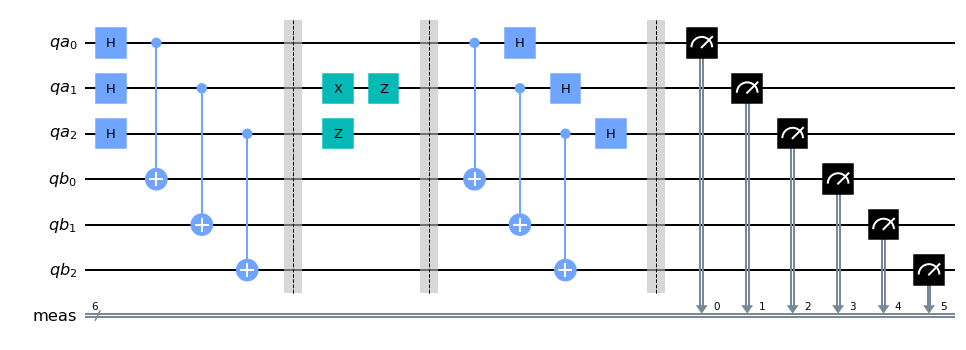

In [52]:
circuit = superdense_coder("001101")
circuit.draw(output='mpl')

## Simulating the Circuit

In [53]:
def canonical_bitstring(bs):
    """ converts the measurement result bitstring into
        a canonical bitstring
    """
    N = len(bs)//2
    bs2 = []
    for i in range(N):
        bs2.append(bs[i+N])
        bs2.append(bs[i])
    return ''.join(bs2)

def simulate_circuit(circuit, n_samples=1000):
    """ simulates a quantum circuit, returning measured bitstrings """
    
    sim = Aer.get_backend('qasm_simulator')
    tqc = transpile(circuit, sim)
    counts = sim.run(tqc,n_samples).result().get_counts(circuit)
    return { 
        canonical_bitstring(bs[::-1]) : count
        for bs, count in counts.items()
    }


In [54]:
results = simulate_circuit(circuit)
print('Measurement Results:')
print('---------------------')
for k, v in results.items():
    print(f'\"{k}\": observed {v} times')

Measurement Results:
---------------------
"001101": observed 1024 times
